# Exploratory ramification data analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from os.path import join, isfile, isdir
import os

def transform_distance_matrix(distance_df):
    """
    Transform a symmetric distance matrix to a long format with 
    columns: cell_a, cell_b, distance
    
    Parameters:
    distance_df (pd.DataFrame): A symmetric distance matrix where rows and columns
                                represent cell labels
    
    Returns:
    pd.DataFrame: A DataFrame with columns: cell_a, cell_b, distance
    """
    # Create an empty list to store the transformed data
    transformed_data = []
    
    # Get the cell labels (should be the same for rows and columns)
    cell_labels = distance_df.columns.tolist()
    
    # Iterate through the upper triangle of the matrix
    # (since the matrix is symmetric, we only need half of it)
    for i, cell_a in enumerate(cell_labels):
        for j, cell_b in enumerate(cell_labels):
            # Only process if i < j to avoid duplicates and self-distances
            if i < j:
                # Get the distance value
                distance = distance_df.loc[cell_a, int(cell_b)]
        
                
                # Add the data to our list
                transformed_data.append({
                    'cell_a': cell_a,
                    'cell_b': cell_b,
                    'distance': distance
                })
    
    # Convert the list to a DataFrame
    result_df = pd.DataFrame(transformed_data)
    
    return result_df

dataset_dir = '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)'

#Identify folders within dataset_dir - these are individual samples
samples = [f for f in os.listdir(dataset_dir) if isdir(join(dataset_dir, f))]

#For each sample, check if it contains a folder that has 'processed' in its name
sample_to_ramification_csv = {}
depth_df = pd.DataFrame()
metrics_df = pd.DataFrame()
k_nearest_neighbors_df = pd.DataFrame()
nearest_neighbors = 1

for sample in samples:
    sample_dir = join(dataset_dir, sample)
    sample_subdirs = [f for f in os.listdir(sample_dir) if isdir(join(sample_dir, f))]
    for subdir in sample_subdirs:
        if 'processed' in subdir:
            processed_sample_dir = join(sample_dir, subdir)
            #Check if the processed sample directory contains a csv file with 'ramification_summary' in its name
            ramification_csv = [f for f in os.listdir(processed_sample_dir) if 'ramification_summary' in f]

            single_volume_depth_df = pd.read_csv(join(processed_sample_dir, 'depth_df_ramified.csv'))
            single_volume_depth_df['sample'] = sample
            depth_df = pd.concat([depth_df, single_volume_depth_df])

            single_volume_metrics_df = pd.read_csv(join(processed_sample_dir, 'metrics_df_ramified.csv'))
            single_volume_metrics_df['sample'] = sample
            metrics_df = pd.concat([metrics_df, single_volume_metrics_df])

            single_volume_distances_df = pd.read_csv(join(processed_sample_dir, 'distances_matrix_ramified.csv'))
            #The first column is the label of cell a and column names are the labels of cell b; we need to reshape the dataframe to have columns: label_a, label_b, distance
            #Set first column as index
            single_volume_distances_df.set_index(single_volume_distances_df.columns[0], inplace=True)
            #Make sure column name data type is int
            single_volume_distances_df.columns = single_volume_distances_df.columns.astype(int)
            single_volume_distances_df = transform_distance_matrix(single_volume_distances_df)
            #For each cell, get the k nearest neighbors
            for cell_label in single_volume_distances_df['cell_a'].unique():
                cell_distances = single_volume_distances_df[single_volume_distances_df['cell_a'] == cell_label]
                #Sort the distances in ascending order
                cell_distances = cell_distances.sort_values('distance')
                cell_distances = cell_distances.head(nearest_neighbors)
                cell_distances['sample'] = sample
                k_nearest_neighbors_df = pd.concat([k_nearest_neighbors_df, cell_distances])

            if len(ramification_csv) == 1:
                sample_to_ramification_csv[sample] = join(processed_sample_dir, ramification_csv[0])

#For each processed sample, check if it contains a csv file with 'ramification_summary' in its name
print(sample_to_ramification_csv)
#Only keep "label", "depth_um", and "sample" columns
depth_df = depth_df[['label', 'depth_um', 'sample']]

#Merge depth_df ape the dataframe to have columns: label_a, label_b, distancewith metrics_df on "label" and "sample"
merged_metrics_df = pd.merge(depth_df, metrics_df, on=['label', 'sample'])
merged_metrics_df.head()

{'G': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/G/G_processed_ramified/ramification_summary_ramified.csv', 'J': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/J/J_processed_ramified/ramification_summary_ramified.csv', 'C': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/C/C_processed_ramified/ramification_summary_ramified.csv', 'N': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/N/N_processed_ramified/ramification_summary_ramified.csv', 'D': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/D/D_processed_ramified/ramification_summary_ramified.csv', 'M': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/M/M_processed_ramified/ramification_summary_ramified.csv', 'L': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/L/L_processed_ramified/ramification_summary_ramified.csv', 'I': '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/I/I_processed_ramified/ramification_summary_ramified.csv',

,label,depth_um,sample,Unnamed: 0,volume_um3,surface_area_um2,voxel_count,bounding_box_volume_um3,sphericity,num_skeleton_nodes,num_branch_points,num_endpoints,total_skeleton_length_um,longest_path_length_um,avg_branch_length_um,max_branch_length_um,min_branch_length_um,avg_tortuosity,branch_count
0,1,5.969231,G,0,8731.103338,7735.890337,115027,117497.012654,0.265066,1138,86,43,505.368010,187.070476,3.239539,18.556409,0.276217,1.131303,156
1,2,14.923077,G,1,4537.969460,4184.127962,59785,73474.951604,0.316801,588,48,32,287.925657,97.015784,3.221538,15.622306,0.276217,1.196007,87
2,4,20.892308,G,2,4066.372834,4231.070310,53572,49770.029191,0.291187,624,56,28,300.444422,101.495955,3.065759,20.188992,0.276217,1.165823,98
3,5,22.882051,G,3,6072.461232,5609.714916,80001,69257.072755,0.286937,713,59,35,360.285230,89.868772,3.398917,27.353967,0.276217,1.159425,106
4,6,13.928205,G,4,2013.451165,2050.024500,26526,10643.373383,0.376143,217,14,10,88.273056,44.819812,3.395118,12.157420,0.276217,1.195760,26


# Plot volume against depth

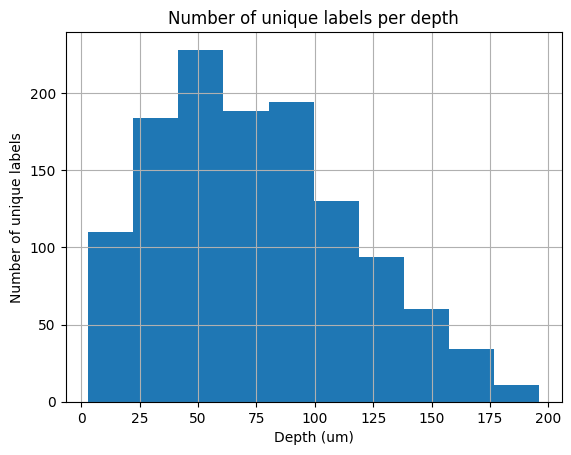

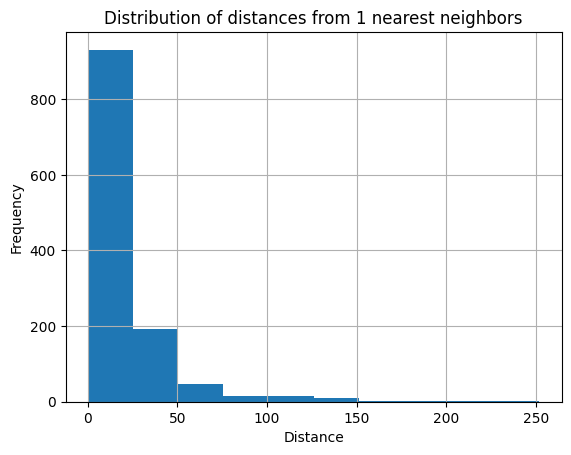

In [3]:
#Plot a histogram of the number of unique labels per depth
depth_df['depth_um'].hist()
plt.xlabel('Depth (um)')
plt.ylabel('Number of unique labels')
plt.title('Number of unique labels per depth')
plt.show()

#Plot the swarm plot of volume_um3 against depth_um
fig = px.scatter(merged_metrics_df, x='depth_um', y='volume_um3', color='sample', title='Volume (um3) vs Depth (um)')
fig.show()

#Plot the swarm plot of num_endpoints against depth_um
fig = px.scatter(merged_metrics_df, x='depth_um', y='num_endpoints', color='sample', title='Number of endpoints vs Depth (um)')
fig.show()

#Plot a histogram of distance from the k_nearest_neighbors_df
k_nearest_neighbors_df['distance'].hist()
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title(f'Distribution of distances from {nearest_neighbors} nearest neighbors')
plt.show()

In [3]:
# Load the data
df = pd.read_csv(sample_to_ramification_csv['A'])

# 1. Basic exploratory analysis
def explore_microglia_data(df):
    # Summary statistics
    print("Summary Statistics:")
    stats = df.describe()
    isfile
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, 
        cols=2,
        subplot_titles=(
            "Distribution of Branch Points", 
            "Distribution of Total Skeleton Length",
            "Distribution of Longest Path Length",
            "Distribution of Average Branch Length"
        )
    )
    
    # Add histograms
    fig.add_trace(
        go.Histogram(x=df['num_branch_points'], nbinsx=20, name="Branch Points"),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=df['total_skeleton_length_um'], nbinsx=20, name="Total Length (μm)"),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Histogram(x=df['longest_path_length_um'], nbinsx=20, name="Longest Path (μm)"),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Histogram(x=df['avg_branch_length_um'], nbinsx=20, name="Avg Branch Length (μm)"),
        row=2, col=2
    )
    
    fig.update_layout(
        height=800, 
        width=1000,
        title_text="Distributions of Key Morphological Features",
        showlegend=False
    )
    
    return fig, stats

# 2. Correlation analysis
def correlation_analysis(df):
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Create heatmap with Plotly
    fig = px.imshow(
        corr_matrix,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        color_continuous_scale='Viridis',
        title="Correlation Matrix of Morphological Features"
    )
    
    fig.update_layout(
        width=900,
        height=800,
        xaxis=dict(tickangle=45),
    )
    
    return fig, corr_matrix

# 3. Relationship visualization
def visualize_relationships(df):
    # Scatter plot matrix for key metrics
    key_metrics = ['num_branch_points', 'num_endpoints', 'total_skeleton_length_um', 
                  'longest_path_length_um', 'avg_branch_length_um', 'avg_tortuosity']
    
    fig = px.scatter_matrix(
        df,
        dimensions=key_metrics,
        title="Scatter Matrix of Key Morphological Metrics",
        opacity=0.7
    )
    
    fig.update_layout(
        width=1000,
        height=1000
    )
    
    return fig

# 4. 3D visualization of key parameters
def create_3d_scatter(df):
    fig = px.scatter_3d(
        df, 
        x='num_branch_points', 
        y='total_skeleton_length_um', 
        z='longest_path_length_um',
        color='avg_tortuosity',
        size='num_skeleton_nodes',
        opacity=0.7,
        title="3D Relationship Between Key Morphological Parameters"
    )
    
    fig.update_layout(
        width=900,
        height=700
    )
    
    return fig

# Function to identify and visualize potential cell clusters
def analyze_cell_clusters(df):
    # Create a scatter plot colored by branch count
    fig = px.scatter(
        df, 
        x='total_skeleton_length_um', 
        y='num_branch_points',
        size='num_skeleton_nodes',
        color='avg_tortuosity',
        hover_data=['label', 'num_endpoints', 'longest_path_length_um'],
        title="Potential Microglial Cell Clusters"
    )
    
    # Add trendline
    fig.update_layout(
        width=900,
        height=700,
        xaxis_title="Total Skeleton Length (μm)",
        yaxis_title="Number of Branch Points"
    )
    
    return fig

# For comparing across multiple volumes or conditions
def compare_conditions(df_list, condition_names):
    """
    Compare key metrics across different conditions
    
    Parameters:
    df_list: List of DataFrames, one for each condition
    condition_names: List of condition names corresponding to each DataFrame
    """
    # For demonstration, we'll create some synthetic data
    # In practice, you'd use your actual dataframes
    
    # Prepare data for plotting
    data_for_boxplot = []
    
    # Key metrics to compare
    metrics = ['num_branch_points', 'total_skeleton_length_um', 
               'longest_path_length_um', 'avg_branch_length_um', 'avg_tortuosity']
    
    # In real usage, you would iterate through your actual dataframes
    # This is just simulating multiple conditions with the same data
    for i, condition in enumerate(condition_names):
        temp_df = df.copy()  # Using same df for demo
        temp_df['condition'] = condition
        data_for_boxplot.append(temp_df)
    
    combined_df = pd.concat(data_for_boxplot)
    
    # Create box plots for each metric
    figs = []
    for metric in metrics:
        fig = px.box(
            combined_df, 
            x='condition', 
            y=metric, 
            color='condition',
            title=f"Comparison of {metric} Across Conditions",
            points="all"
        )
        figs.append(fig)
    
    return figs

# Example usage (for multiple conditions):
# condition_dfs = [df1, df2, df3]  # Your actual dataframes
# condition_names = ['Control', 'Treatment A', 'Treatment B']
# comparison_figs = compare_conditions(condition_dfs, condition_names)

In [5]:
fig, stats = explore_microglia_data(df)
fig.show()

fig, corr_matrix = correlation_analysis(df)
fig.show()

fig = visualize_relationships(df)
fig.show()

fig = create_3d_scatter(df)
fig.show()

fig = analyze_cell_clusters(df)
fig.show()

Summary Statistics:


In [ ]:
color_options = ['#00312F', '#1D2D46', '#46000D', '#5F3920', '#573844', '#424313']

--- Original Palette ---
['#00312F', '#1D2D46', '#46000D', '#5F3920', '#573844', '#424313']
--- Pastel Palette ---
['#90e3e0', '#b2bed1', '#e595a4', '#d7c2b4', '#cfc1c6', '#d4d5aa']
------------------------------

--- Loading Group Assignment Data from: /home/kirill/Desktop/For_Kirill/iba1 Morpho_group.csv ---
--- Group Assignments Loaded ---
  Image_ID Experimental_Group
0        A             Group1
1        H             Group2
2        I             Group2
3        B             Group1
4        J             Group2
Total group assignments: 14
------------------------------

--- Scanning for Metrics Files in: /home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy) ---
Found potential image ID directories: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

Successfully loaded metrics for A (150 cells) from '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)/A/A_processed_ramified/metrics_df_ramified.csv'
Successfully loaded metrics for B (141 cells) 

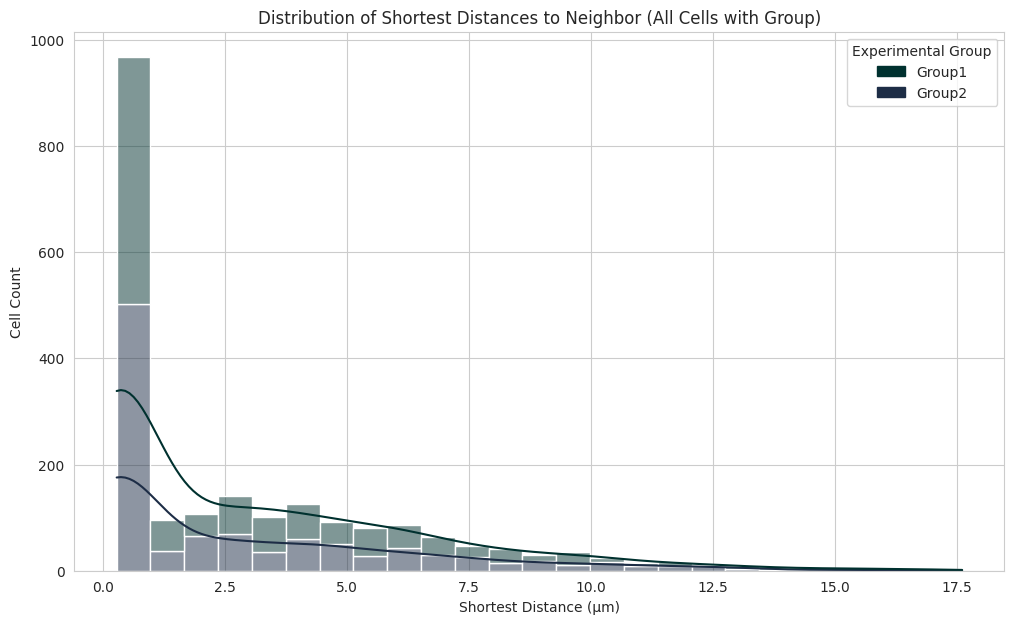

/tmp/ipykernel_13648/1644150631.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=avg_shortest_distance_per_image, x='Experimental_Group', y='shortest_distance_um', order=valid_groups, palette=pastel_palette_map, showfliers=False)


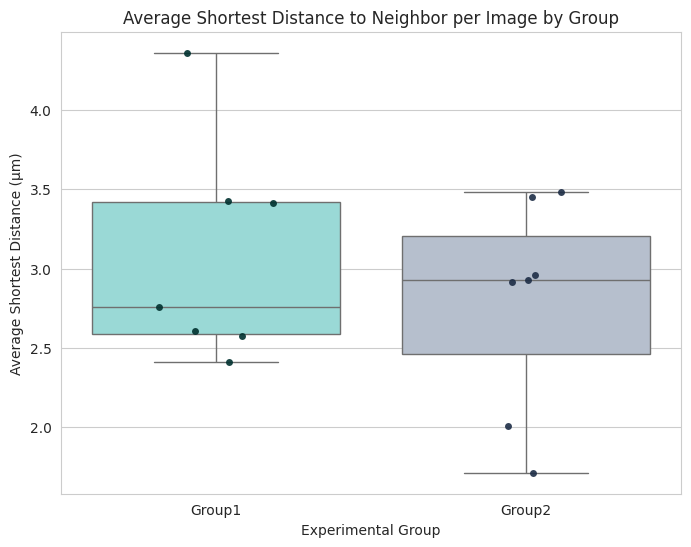

T-test (Avg Shortest Dist) Group1 vs Group2: Stat=0.817, P=0.4301 
------------------------------

--- Analyzing Ramification Metrics ---


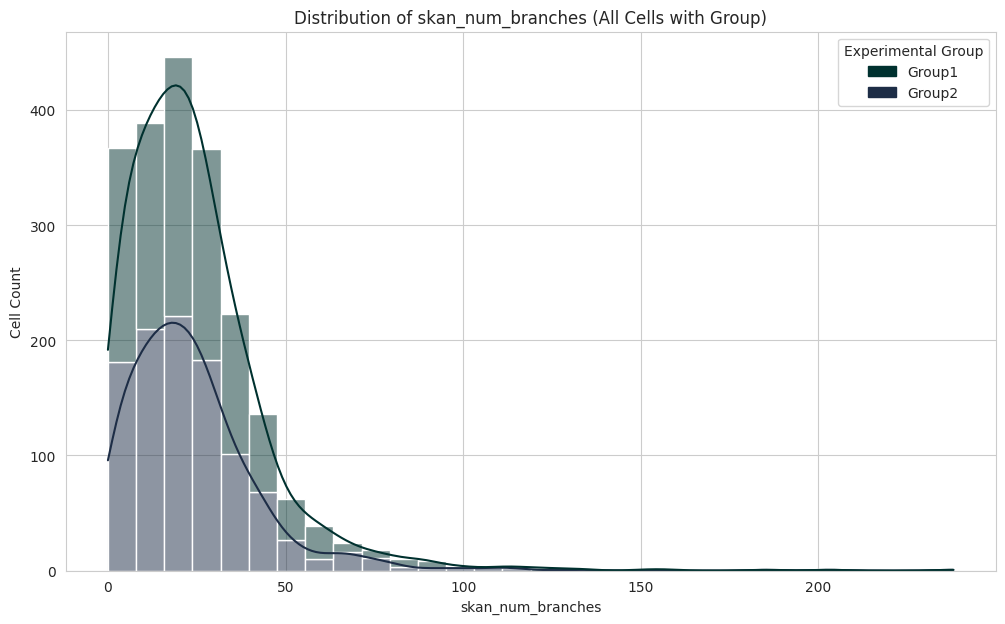

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


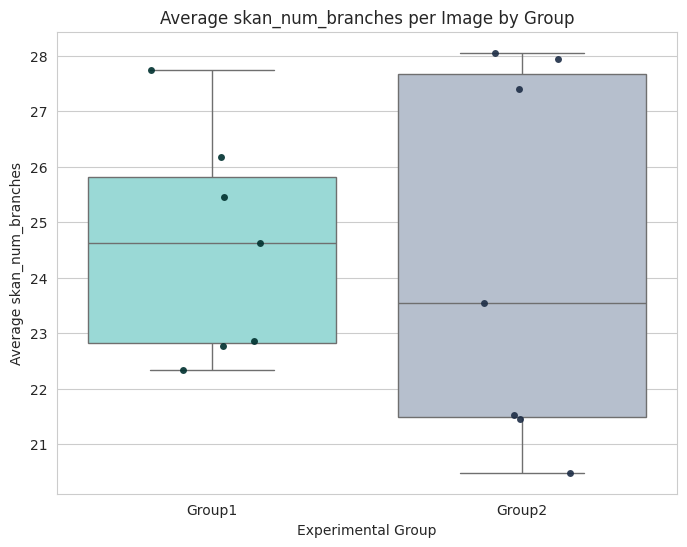

T-test (Avg skan_num_branches) Group1 vs Group2: Stat=0.151, P=0.8823 
--------------------


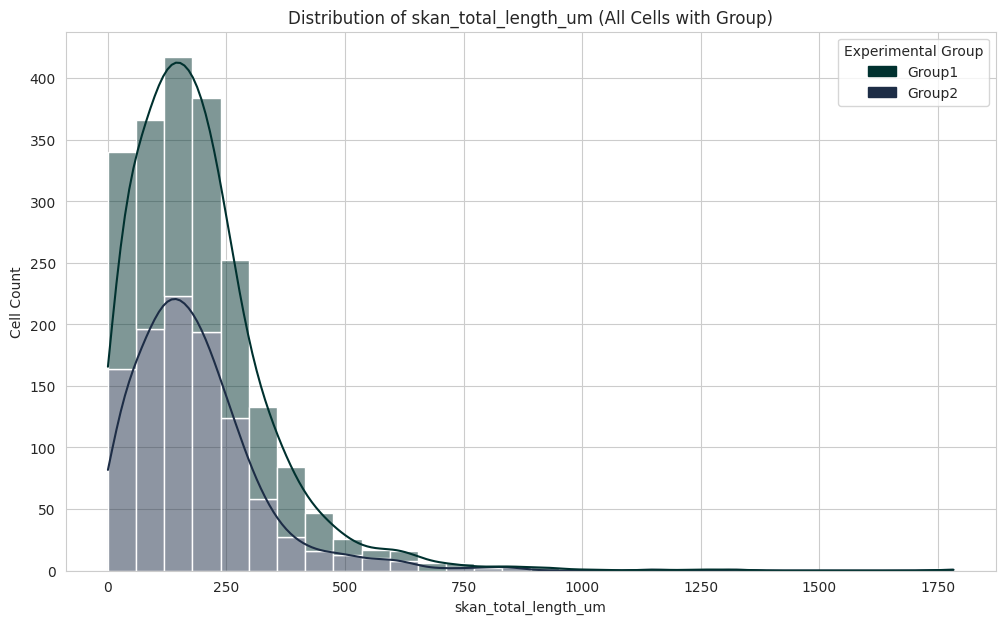

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


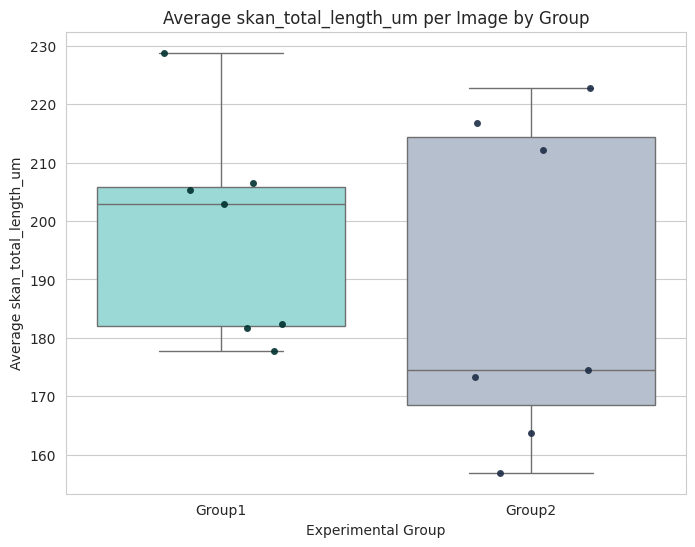

T-test (Avg skan_total_length_um) Group1 vs Group2: Stat=0.744, P=0.4712 
--------------------


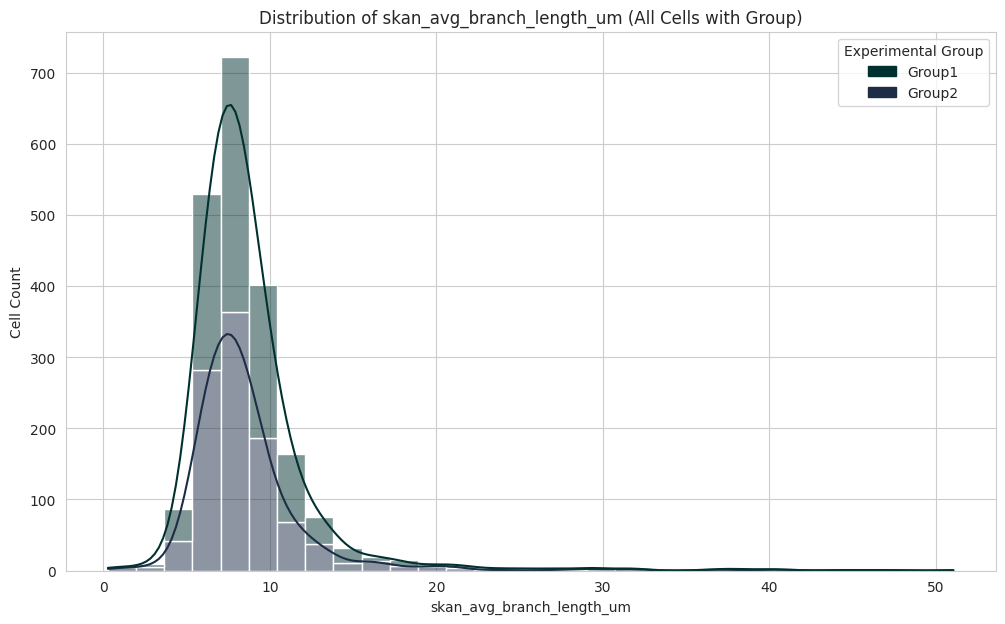

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


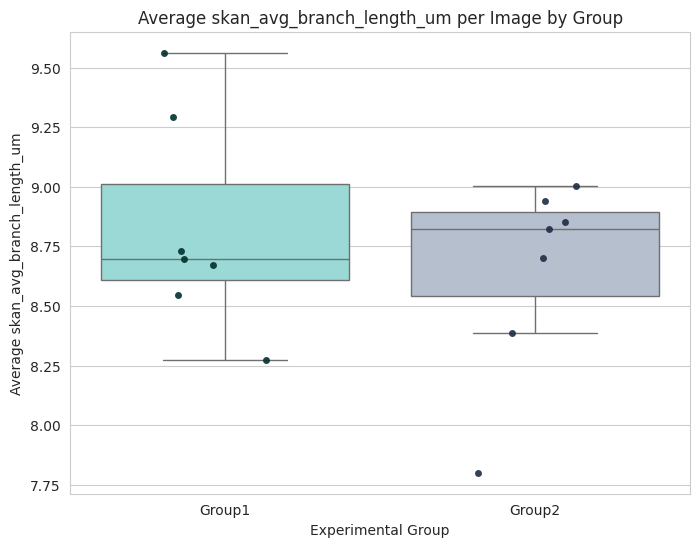

T-test (Avg skan_avg_branch_length_um) Group1 vs Group2: Stat=0.781, P=0.4497 
--------------------


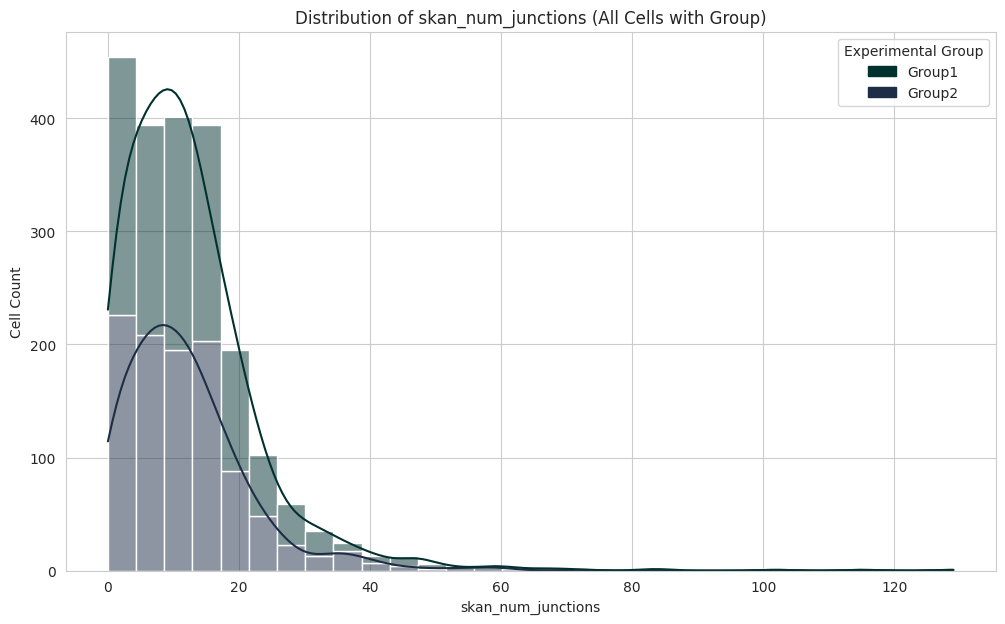

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


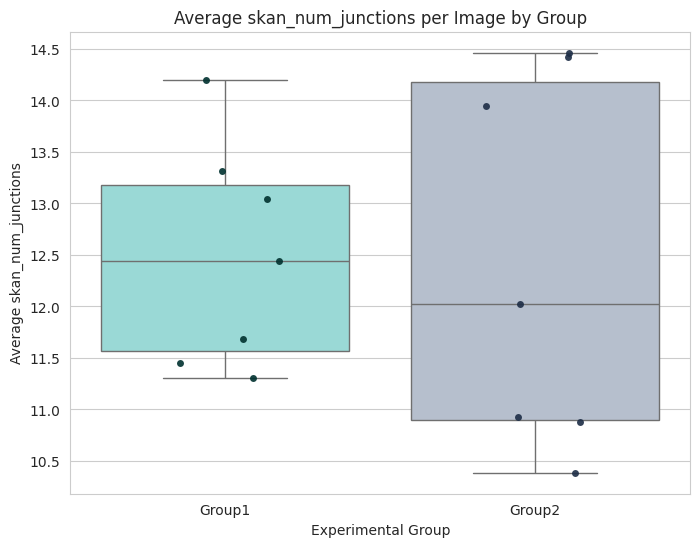

T-test (Avg skan_num_junctions) Group1 vs Group2: Stat=0.072, P=0.9439 
--------------------


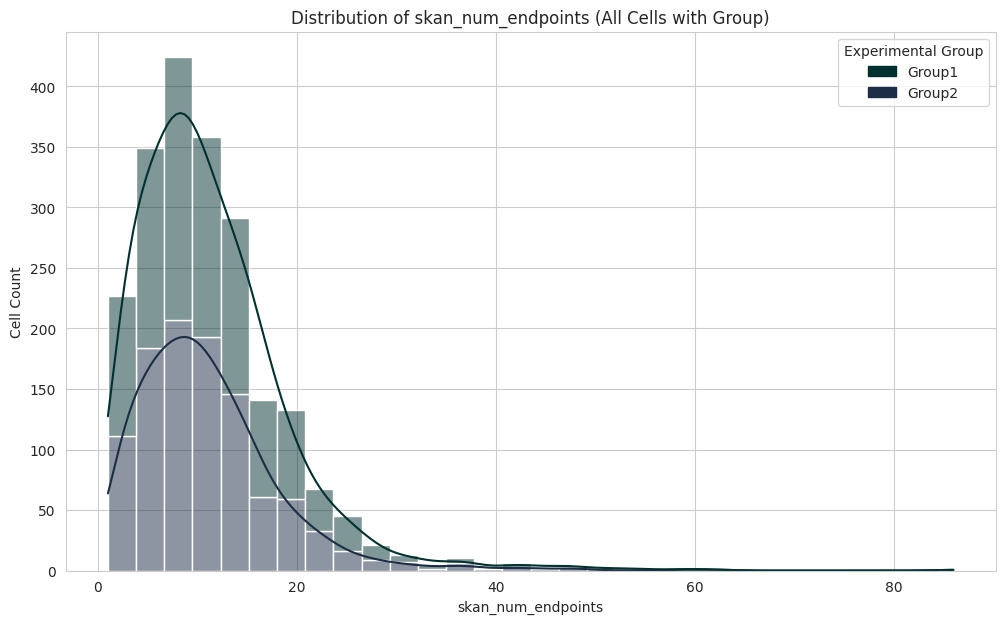

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


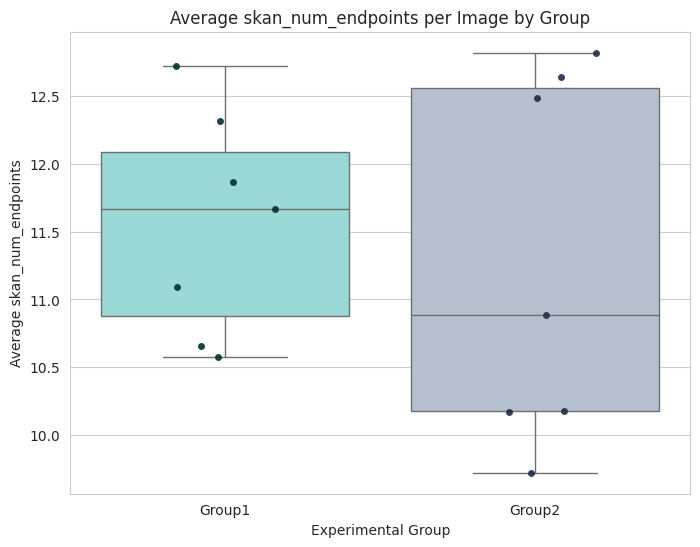

T-test (Avg skan_num_endpoints) Group1 vs Group2: Stat=0.481, P=0.6389 
--------------------


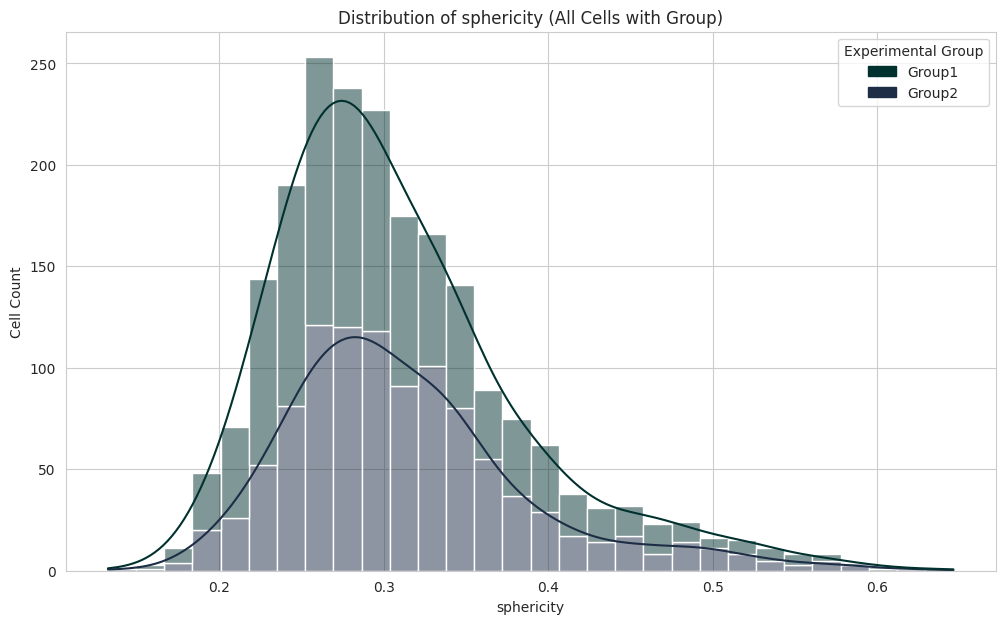

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


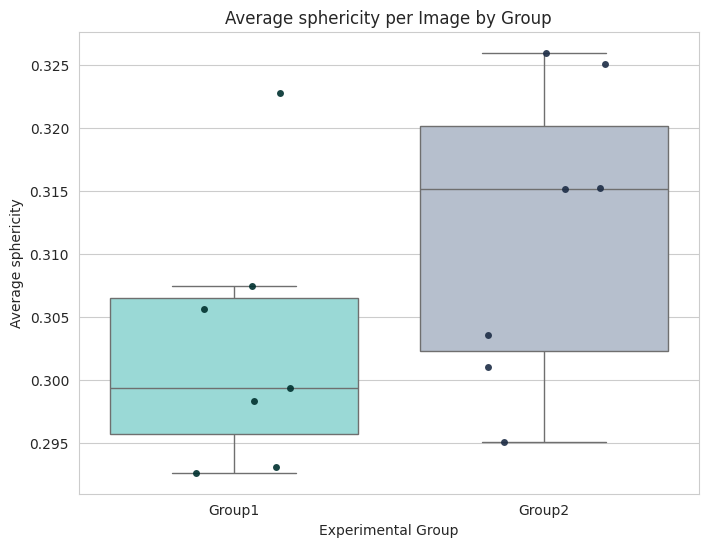

T-test (Avg sphericity) Group1 vs Group2: Stat=-1.463, P=0.1692 
--------------------


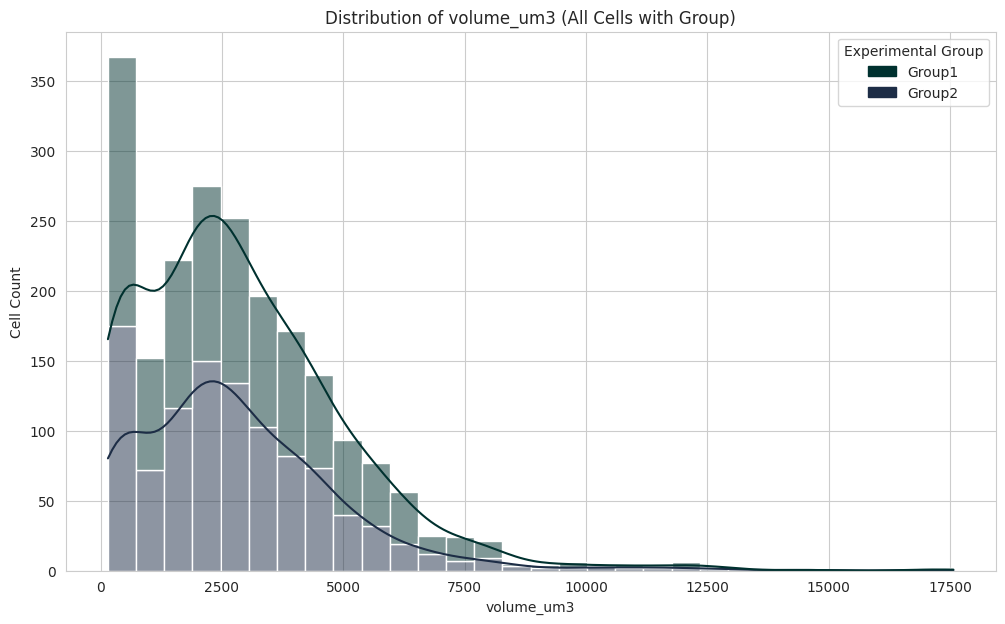

/tmp/ipykernel_13648/1644150631.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)


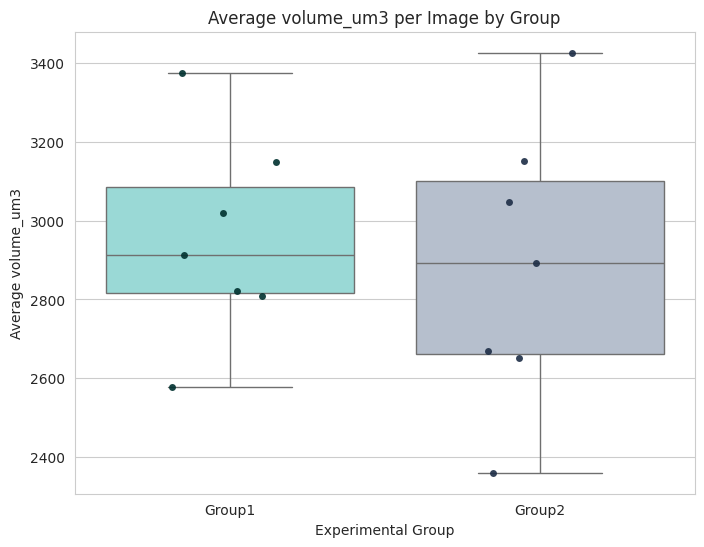

T-test (Avg volume_um3) Group1 vs Group2: Stat=0.402, P=0.6948 
--------------------
------------------------------



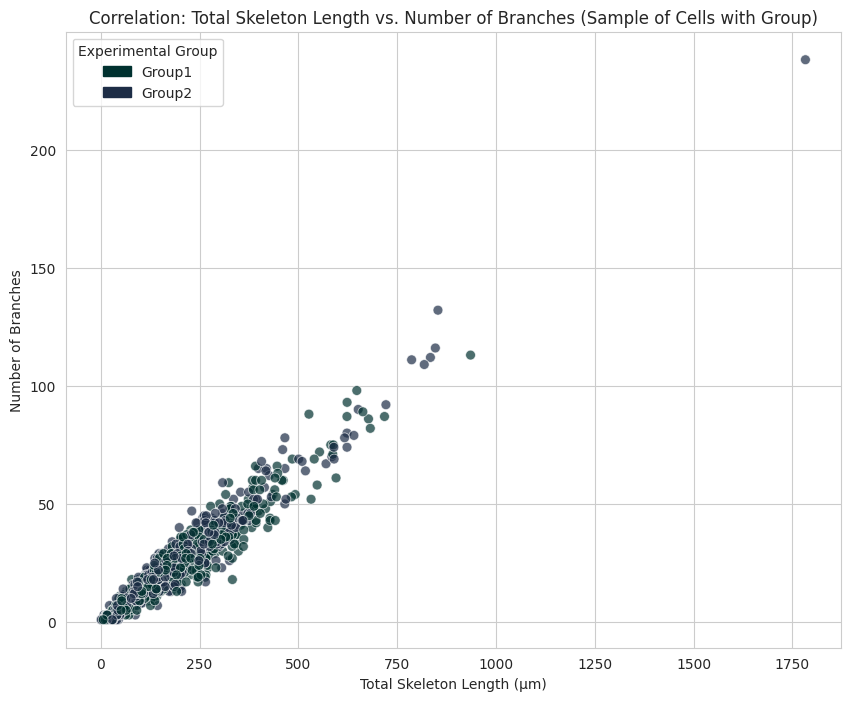

--- Analysis Complete ---


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
import colorsys
import matplotlib.colors as mcolors

# --- Configuration ---
BASE_DIR = '/home/kirill/Desktop/For_Kirill/Iba1_Morpho_BB_Blind (Copy)'
GROUP_INFO_FILE = '/home/kirill/Desktop/For_Kirill/iba1 Morpho_group.csv'
METRICS_FILENAME = 'metrics_df_ramified.csv'

# Original custom color palette
ORIGINAL_CUSTOM_PALETTE = ['#00312F', '#1D2D46', '#46000D', '#5F3920', '#573844', '#424313']

# --- Helper Function to Create Pastel Colors ---
def make_pastel(hex_color, lightness_scale=0.7, saturation_scale=0.6):
    try:
        rgb_normalized = mcolors.to_rgb(hex_color)
        h, l, s = colorsys.rgb_to_hls(rgb_normalized[0], rgb_normalized[1], rgb_normalized[2])
        l_pastel = l + (1.0 - l) * lightness_scale
        l_pastel = min(1.0, max(0.0, l_pastel))
        s_pastel = s * saturation_scale
        s_pastel = min(1.0, max(0.0, s_pastel))
        rgb_pastel_normalized = colorsys.hls_to_rgb(h, l_pastel, s_pastel)
        pastel_hex = mcolors.to_hex(rgb_pastel_normalized)
        return pastel_hex
    except ValueError:
        print(f"Warning: Could not convert color {hex_color} to pastel. Returning original.")
        return hex_color

# --- Generate Pastel Palette ---
PASTEL_PALETTE = [make_pastel(color) for color in ORIGINAL_CUSTOM_PALETTE]
print("--- Original Palette ---")
print(ORIGINAL_CUSTOM_PALETTE)
print("--- Pastel Palette ---")
print(PASTEL_PALETTE)
print("-" * 30 + "\n")

# --- 1. Load Group Assignment Data ---
print(f"--- Loading Group Assignment Data from: {GROUP_INFO_FILE} ---")
try:
    group_df_raw = pd.read_csv(GROUP_INFO_FILE)
    group_df_raw = group_df_raw.rename(columns={'Unnamed: 0': 'Batch'})
except FileNotFoundError:
    print(f"FATAL ERROR: Group info file '{GROUP_INFO_FILE}' not found. Please check the path.")
    raise
except Exception as e:
    print(f"FATAL ERROR: Could not load group info file '{GROUP_INFO_FILE}': {e}")
    raise

group_assignments = []
for _, row in group_df_raw.iterrows():
    if pd.notna(row['Group1']):
        group_assignments.append({'Image_ID': str(row['Group1']).strip(), 'Experimental_Group': 'Group1'})
    if pd.notna(row['Group2']):
        group_assignments.append({'Image_ID': str(row['Group2']).strip(), 'Experimental_Group': 'Group2'})

group_assignment_df = pd.DataFrame(group_assignments)
if group_assignment_df.empty:
    print("Warning: No group assignments were parsed. Check the content of 'iba1 Morpho_group.csv'.")
else:
    print("--- Group Assignments Loaded ---")
    print(group_assignment_df.head())
    print(f"Total group assignments: {len(group_assignment_df)}")
print("-" * 30 + "\n")

# --- 2. Find and Load All Metrics Files ---
print(f"--- Scanning for Metrics Files in: {BASE_DIR} ---")
all_metrics_data = []
if not os.path.isdir(BASE_DIR):
    print(f"FATAL ERROR: Base directory '{BASE_DIR}' not found. Please check the path.")
    raise FileNotFoundError(f"Base directory '{BASE_DIR}' not found.")
try:
    image_id_dirs = sorted([
        d for d in os.listdir(BASE_DIR)
        if os.path.isdir(os.path.join(BASE_DIR, d)) and len(d) == 1 and d.isalpha() and d.isupper()
    ])
except FileNotFoundError:
    print(f"FATAL ERROR: Could not list directories in '{BASE_DIR}'. Path may be incorrect or inaccessible.")
    raise
print(f"Found potential image ID directories: {image_id_dirs}\n")
for image_id in image_id_dirs:
    metrics_file_path = os.path.join(BASE_DIR, image_id, f"{image_id}_processed_ramified", METRICS_FILENAME)
    if os.path.exists(metrics_file_path):
        try:
            df = pd.read_csv(metrics_file_path)
            if df.empty:
                print(f"Warning: Metrics file for {image_id} at '{metrics_file_path}' is empty. Skipping.")
                continue
            df['Image_ID'] = image_id
            all_metrics_data.append(df)
            print(f"Successfully loaded metrics for {image_id} ({len(df)} cells) from '{metrics_file_path}'")
        except Exception as e:
            print(f"Error loading metrics for {image_id} from '{metrics_file_path}': {e}. Skipping.")
    else:
        processed_dir_path = os.path.join(BASE_DIR, image_id, f"{image_id}_processed_ramified")
        if not os.path.isdir(processed_dir_path):
             print(f"Warning: Processed directory not found for {image_id}: '{processed_dir_path}'. Skipping.")
        else:
            print(f"Warning: Metrics file not found for {image_id} at '{metrics_file_path}'. This might be expected. Skipping.")

if not all_metrics_data:
    print("\nFATAL ERROR: No metrics data was loaded. Please check paths, file availability, and naming conventions.")
    # In a notebook, execution would stop. For a script, you might `exit()`.
else:
    combined_df = pd.concat(all_metrics_data, ignore_index=True)
    print(f"\n--- Combined Metrics Data ({len(combined_df)} total cells from {len(all_metrics_data)} images) ---")
    print(combined_df.head())
    print("-" * 30 + "\n")

    # --- 3. Merge Metrics Data with Group Assignments ---
    combined_df['Image_ID'] = combined_df['Image_ID'].astype(str)
    merged_df = pd.merge(combined_df, group_assignment_df, on='Image_ID', how='left')
    loaded_image_ids = combined_df['Image_ID'].unique()
    assigned_image_ids = group_assignment_df['Image_ID'].unique()
    unassigned_images = set(loaded_image_ids) - set(assigned_image_ids)
    if unassigned_images:
        print(f"Warning: Image_IDs with data but no group assignment: {sorted(list(unassigned_images))}")
    images_in_groups_not_loaded = set(assigned_image_ids) - set(loaded_image_ids)
    if images_in_groups_not_loaded:
        print(f"Warning: Image_IDs in groups but no data loaded: {sorted(list(images_in_groups_not_loaded))}")
    print("--- Merged Data with Group Information ---")
    print(merged_df.head())
    print(f"Value counts for Experimental_Group (after merge):\n{merged_df['Experimental_Group'].value_counts(dropna=False)}")
    print("-" * 30 + "\n")
    plot_df = merged_df.copy()

    # --- 4. Analyze and Plot Data ---
    sns.set_style("whitegrid")
    valid_groups = sorted(plot_df['Experimental_Group'].dropna().unique())
    if not valid_groups:
        print("Warning: No valid experimental groups found for plotting. Plots might be empty or fail.")

    # Create palette maps
    original_palette_map = {group: ORIGINAL_CUSTOM_PALETTE[i % len(ORIGINAL_CUSTOM_PALETTE)] for i, group in enumerate(valid_groups)}
    pastel_palette_map = {group: PASTEL_PALETTE[i % len(PASTEL_PALETTE)] for i, group in enumerate(valid_groups)}

    # --- 4.a. Closest Neighbor Distances ---
    print("--- Analyzing Shortest Distances ---")
    if 'shortest_distance_um' in plot_df.columns and valid_groups:
        plt.figure(figsize=(12, 7))
        sns.histplot(data=plot_df.dropna(subset=['Experimental_Group']), x='shortest_distance_um', hue='Experimental_Group', kde=True, multiple='stack', palette=original_palette_map, hue_order=valid_groups)
        plt.title('Distribution of Shortest Distances to Neighbor (All Cells with Group)')
        plt.xlabel('Shortest Distance (µm)')
        plt.ylabel('Cell Count')
        if valid_groups:
             plt.legend(title='Experimental Group', handles=[plt.Rectangle((0,0),1,1, color=original_palette_map[group]) for group in valid_groups], labels=valid_groups)
        plt.show()

        avg_shortest_distance_per_image = plot_df.groupby(['Image_ID', 'Experimental_Group'])['shortest_distance_um'].mean().reset_index()
        avg_shortest_distance_per_image = avg_shortest_distance_per_image.dropna(subset=['Experimental_Group'])

        if not avg_shortest_distance_per_image.empty:
            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(data=avg_shortest_distance_per_image, x='Experimental_Group', y='shortest_distance_um', order=valid_groups, palette=pastel_palette_map, showfliers=False)
            
            # Iterate over groups to plot stripplot points with correct original color
            for group_name in valid_groups:
                current_group_data = avg_shortest_distance_per_image[avg_shortest_distance_per_image['Experimental_Group'] == group_name]
                if not current_group_data.empty:
                    sns.stripplot(
                        data=current_group_data,       # Data for the current group
                        x='Experimental_Group',        # Categorical column
                        y='shortest_distance_um',      # Value column
                        order=valid_groups,            # Global order for x-axis alignment
                        color=original_palette_map[group_name], # Specific color for this group
                        alpha=0.9, 
                        jitter=0.2, 
                        size=5, 
                        ax=ax
                    )

            # ax.set_xticks(range(len(valid_groups))) # Keep if you want to be explicit
            # ax.set_xticklabels(valid_groups)      # Keep if you want to be explicit
            plt.title('Average Shortest Distance to Neighbor per Image by Group')
            plt.xlabel('Experimental Group')
            plt.ylabel('Average Shortest Distance (µm)')
            plt.show()

            # Statistical test
            if len(valid_groups) == 2:
                g1, g2 = valid_groups[0], valid_groups[1]
                v1 = avg_shortest_distance_per_image[avg_shortest_distance_per_image['Experimental_Group'] == g1]['shortest_distance_um'].dropna()
                v2 = avg_shortest_distance_per_image[avg_shortest_distance_per_image['Experimental_Group'] == g2]['shortest_distance_um'].dropna()
                if len(v1) >= 2 and len(v2) >= 2:
                    s, p = ttest_ind(v1, v2, nan_policy='omit')
                    print(f"T-test (Avg Shortest Dist) {g1} vs {g2}: Stat={s:.3f}, P={p:.4f} {'*' if p < 0.05 else ''}")
                else: print("  Not enough data for t-test (shortest distance).")
            elif len(valid_groups) > 2:
                samples = [d['shortest_distance_um'].dropna() for _, d in avg_shortest_distance_per_image.groupby('Experimental_Group')]
                valid_samples = [s for s in samples if len(s) >= 2] # Ensure samples have at least 2 data points
                # Check if all original groups are represented by valid samples for ANOVA
                if len(valid_samples) == len(avg_shortest_distance_per_image['Experimental_Group'].unique()):
                    stat, p_value = f_oneway(*valid_samples)
                    print(f"ANOVA for Average Shortest Distance across {len(valid_samples)} groups:")
                    print(f"  F-Statistic: {stat:.3f}, P-value: {p_value:.4f} {'*' if p_value < 0.05 else ''}")
                else: print("  Not enough data points or groups for ANOVA on shortest distance (some groups might have <2 points).")
        else:
            print("No data for average shortest distance per image analysis.")
    else:
        print("Skipping shortest distance analysis: column missing or no valid groups.")
    print("-" * 30 + "\n")

    # --- 4.b. Ramification Metrics ---
    print("--- Analyzing Ramification Metrics ---")
    ramification_metrics = [
        'skan_num_branches', 'skan_total_length_um', 'skan_avg_branch_length_um', 
        'skan_num_junctions', 'skan_num_endpoints', 'sphericity', 'volume_um3'
    ]
    avg_ramification_per_image = plot_df.groupby(['Image_ID', 'Experimental_Group'])[ramification_metrics].mean().reset_index()
    avg_ramification_per_image = avg_ramification_per_image.dropna(subset=['Experimental_Group'])

    if not avg_ramification_per_image.empty and valid_groups:
        for metric in ramification_metrics:
            if metric not in plot_df.columns:
                print(f"Skipping metric '{metric}': column not found.")
                continue

            plt.figure(figsize=(12, 7))
            sns.histplot(data=plot_df.dropna(subset=['Experimental_Group']), x=metric, hue='Experimental_Group', kde=True, multiple='stack', bins=30, palette=original_palette_map, hue_order=valid_groups)
            plt.title(f'Distribution of {metric} (All Cells with Group)')
            plt.xlabel(metric)
            plt.ylabel('Cell Count')
            if valid_groups:
                plt.legend(title='Experimental Group', handles=[plt.Rectangle((0,0),1,1, color=original_palette_map[group]) for group in valid_groups], labels=valid_groups)
            plt.show()

            metric_avg_per_image = avg_ramification_per_image[['Image_ID', 'Experimental_Group', metric]].dropna(subset=['Experimental_Group', metric]) 
            if metric_avg_per_image.empty:
                print(f"No data for average {metric} per image. Skipping boxplot/stats.")
                continue

            plt.figure(figsize=(8, 6))
            ax = sns.boxplot(data=metric_avg_per_image, x='Experimental_Group', y=metric, order=valid_groups, palette=pastel_palette_map, showfliers=False)
            
            for group_name in valid_groups:
                current_group_data = metric_avg_per_image[metric_avg_per_image['Experimental_Group'] == group_name]
                if not current_group_data.empty:
                    sns.stripplot(
                        data=current_group_data,   # Data for the current group
                        x='Experimental_Group',    # Categorical column
                        y=metric,                  # Value column
                        order=valid_groups,        # Global order for x-axis alignment
                        color=original_palette_map[group_name], # Specific color
                        alpha=0.9, 
                        jitter=0.2, 
                        size=5, 
                        ax=ax
                    )
            # ax.set_xticks(range(len(valid_groups))) # Keep if you want to be explicit
            # ax.set_xticklabels(valid_groups)      # Keep if you want to be explicit
            plt.title(f'Average {metric} per Image by Group')
            plt.xlabel('Experimental Group')
            plt.ylabel(f'Average {metric}')
            plt.show()

            # Statistical test
            if len(valid_groups) == 2:
                g1, g2 = valid_groups[0], valid_groups[1]
                v1 = metric_avg_per_image[metric_avg_per_image['Experimental_Group'] == g1][metric].dropna()
                v2 = metric_avg_per_image[metric_avg_per_image['Experimental_Group'] == g2][metric].dropna()
                if len(v1) >= 2 and len(v2) >= 2:
                    s,p = ttest_ind(v1, v2, nan_policy='omit')
                    print(f"T-test (Avg {metric}) {g1} vs {g2}: Stat={s:.3f}, P={p:.4f} {'*' if p < 0.05 else ''}")
                else: print(f"  Not enough data for t-test on {metric}.")
            elif len(valid_groups) > 2:
                samples = [d[metric].dropna() for _, d in metric_avg_per_image.groupby('Experimental_Group')]
                valid_samples = [s for s in samples if len(s) >= 2]
                if len(valid_samples) == len(metric_avg_per_image['Experimental_Group'].unique()): # Check against unique groups in the *current data*
                    stat, p_value = f_oneway(*valid_samples)
                    print(f"ANOVA for Average {metric} across {len(valid_samples)} groups:")
                    print(f"  F-Statistic: {stat:.3f}, P-value: {p_value:.4f} {'*' if p_value < 0.05 else ''}")
                else: print(f"  Not enough data/groups for ANOVA on {metric} (some groups might have <2 points).")
            print("-" * 20)
    else:
        print("Skipping ramification metrics analysis: No data with groups or aggregated data empty.")
    print("-" * 30 + "\n")
    
    # --- 5. Example: Correlation between metrics (optional) ---
    if not plot_df.empty and 'skan_total_length_um' in plot_df.columns and 'skan_num_branches' in plot_df.columns and valid_groups:
        sample_df_for_corr = plot_df.dropna(subset=['Experimental_Group', 'skan_total_length_um', 'skan_num_branches'])
        if not sample_df_for_corr.empty:
             sample_df_for_corr = sample_df_for_corr.sample(n=min(1000, len(sample_df_for_corr)), random_state=42)
        
        if not sample_df_for_corr.empty:
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=sample_df_for_corr, x='skan_total_length_um', y='skan_num_branches', hue='Experimental_Group', alpha=0.7, palette=original_palette_map, hue_order=valid_groups, s=50)
            plt.title('Correlation: Total Skeleton Length vs. Number of Branches (Sample of Cells with Group)')
            plt.xlabel('Total Skeleton Length (µm)')
            plt.ylabel('Number of Branches')
            if valid_groups:
                plt.legend(title='Experimental Group', handles=[plt.Rectangle((0,0),1,1, color=original_palette_map[group]) for group in valid_groups], labels=valid_groups)
            plt.show()
        else:
            print("Not enough data for correlation plot after filtering.")
    else:
        print("Skipping correlation plot: columns missing or no valid groups.")

    print("--- Analysis Complete ---")